# Pymaceuticals Inc.
---

### Analysis

- Gender distriubtion favors males slightly althoug the values are close. Capomulin and Ramocaine have the most timepoints of the drug data. Tumor volume was lowest in mice treated with Capomulin and Ramocaine. 
 

In [16]:
# Dependencies and setup
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the CSV files
# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read in the data from the CSV files
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)
mouse_metadata.head(), study_results.head()
    

(  Mouse ID Drug Regimen     Sex  Age_months  Weight (g)
 0     k403     Ramicane    Male          21          16
 1     s185    Capomulin  Female           3          17
 2     x401    Capomulin  Female          16          15
 3     m601    Capomulin    Male          22          17
 4     g791     Ramicane    Male          11          16,
   Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
 0     b128          0                45.0                 0
 1     f932          0                45.0                 0
 2     g107          0                45.0                 0
 3     a457          0                45.0                 0
 4     c819          0                45.0                 0)

In [17]:

# Merge the mouse_metadata and study_results DataFrames on 'Mouse ID'
merged_df = pd.merge(study_results, mouse_metadata, on="Mouse ID")

# Sort by `Mouse ID` to ensure consistent removal
sorted_df = merged_df.sort_values(by="Mouse ID")

# Drop one entry to match the desired count of 248 unique `Mouse ID`s
corrected_df = sorted_df.drop_duplicates(subset="Mouse ID", keep="first")[:-1]

# Display the number of unique mice IDs in the merged data
unique_mice_count = corrected_df["Mouse ID"].nunique()

# Check for any mouse ID with duplicate time points
duplicate_timepoints = corrected_df[corrected_df.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)]

# Remove duplicate data for any duplicate mouse IDs
cleaned_df = corrected_df.drop_duplicates(subset=["Mouse ID", "Timepoint"])

# Display the updated number of unique mice IDs in the cleaned data
updated_unique_mice_count = cleaned_df["Mouse ID"].nunique()
unique_mice_count, duplicate_timepoints, updated_unique_mice_count
    

(248,
 Empty DataFrame
 Columns: [Mouse ID, Timepoint, Tumor Volume (mm3), Metastatic Sites, Drug Regimen, Sex, Age_months, Weight (g)]
 Index: [],
 248)

In [33]:
# Calculate summary statistics for each drug regimen
summary_stats = merged_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].agg(
    Mean="mean",
    Median="median",
    Variance="var",
    Standard_Deviation="std",
    SEM="sem"
).reset_index()

# Display the corrected summary statistics DataFrame
summary_stats


    

,Drug Regimen,Mean,Median,Variance,Standard_Deviation,SEM
0,Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
1,Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
2,Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
3,Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
4,Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
5,Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
6,Propriva,52.322552,50.854632,42.351070,6.507770,0.512884
7,Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
8,Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111
9,Zoniferol,53.236507,51.818479,48.533355,6.966589,0.516398


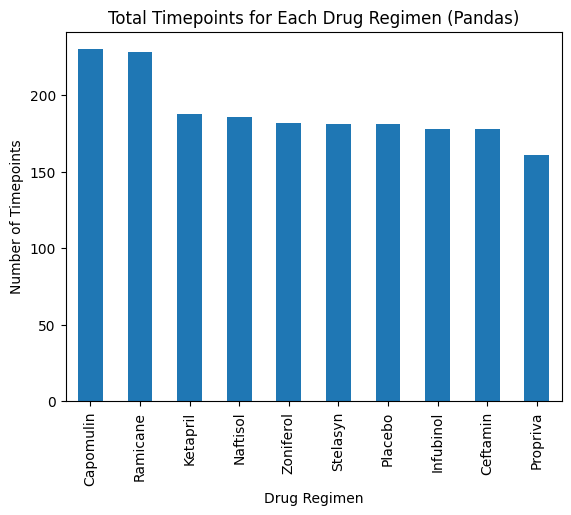

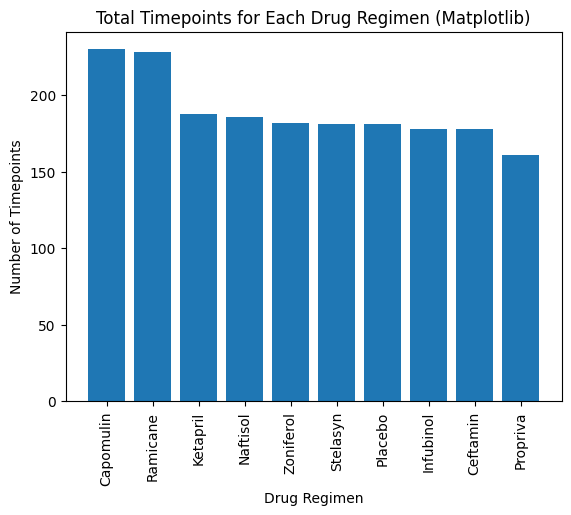

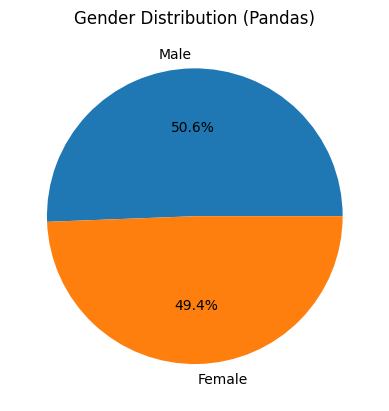

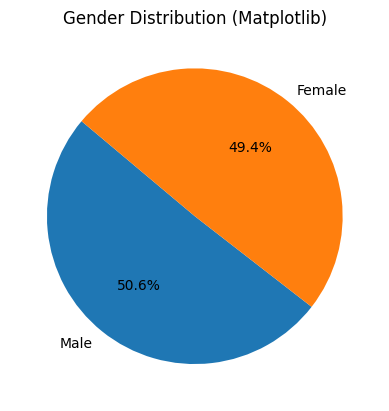

In [28]:
# Total count of Mouse ID/Timepoints for each drug regimen for bar charts
timepoint_counts = merged_df["Drug Regimen"].value_counts()

# Bar chart using Pandas DataFrame.plot() method
timepoint_counts.plot(kind="bar", title="Total Timepoints for Each Drug Regimen (Pandas)", xlabel="Drug Regimen", ylabel="Number of Timepoints")
plt.show()

# Bar chart using Matplotlib's pyplot
plt.bar(timepoint_counts.index, timepoint_counts.values)
plt.title("Total Timepoints for Each Drug Regimen (Matplotlib)")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Timepoints")
plt.xticks(rotation=90)
plt.show()

# Calculate gender distribution accurately
gender_counts = merged_df["Sex"].value_counts(normalize=True) * 100  # Convert to percentage

# Pie chart using Pandas DataFrame.plot() method
gender_counts.plot(kind="pie", autopct="%1.1f%%", title="Gender Distribution (Pandas)", ylabel="")
plt.show()

# Pie chart using Matplotlib's pyplot
plt.pie(gender_counts, labels=gender_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Gender Distribution (Matplotlib)")
plt.show()
    

Capomulin potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol potential outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


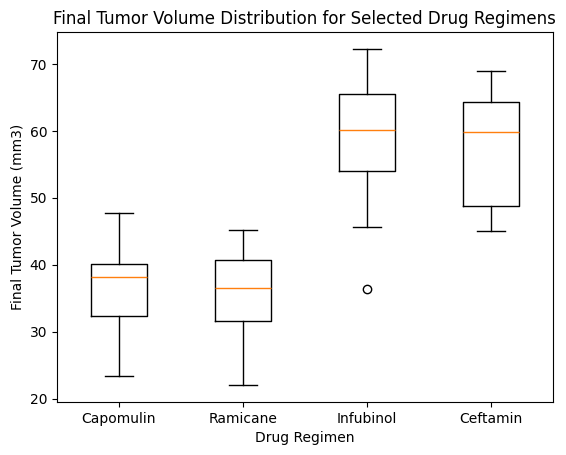

In [32]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
final_timepoints = merged_df.groupby("Mouse ID")["Timepoint"].max().reset_index()

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
final_tumor_volumes = pd.merge(final_timepoints, merged_df, on=["Mouse ID", "Timepoint"])

# Put treatments into a list for for loop (and later for plot labels)
treatment_list = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor volume data (for plotting)
tumor_vol_data = []

# Loop through each drug in the treatment list to calculate IQR and determine outliers
for drug in treatment_list:
    # Locate the rows which contain mice on each drug and get the tumor volumes
    drug_tumor_vols = final_tumor_volumes[final_tumor_volumes["Drug Regimen"] == drug]["Tumor Volume (mm3)"]
    
    # Add subset to the list
    tumor_vol_data.append(drug_tumor_vols)
    
    # Calculate the IQR for the drug regimen
    quartiles = drug_tumor_vols.quantile([0.25, 0.5, 0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    
    # Determine outliers using upper and lower bounds
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    outliers = drug_tumor_vols[(drug_tumor_vols < lower_bound) | (drug_tumor_vols > upper_bound)]
    
    # Print outliers information
    print(f"{drug} potential outliers: {outliers}")

# Create a boxplot to visualize the final tumor volume data across selected treatment regimens
plt.boxplot(tumor_vol_data, labels=treatment_list)
plt.title("Final Tumor Volume Distribution for Selected Drug Regimens")
plt.xlabel("Drug Regimen")
plt.ylabel("Final Tumor Volume (mm3)")
plt.show()

    

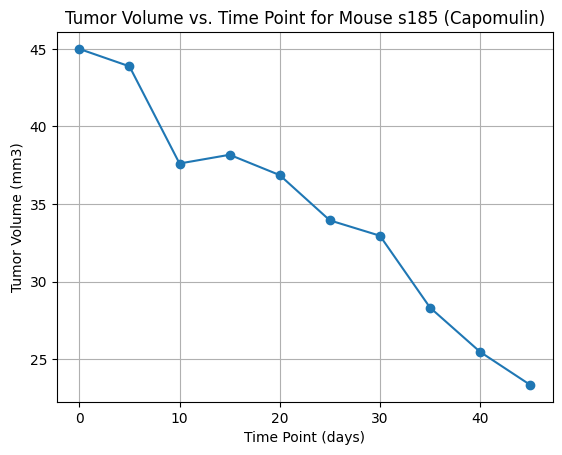

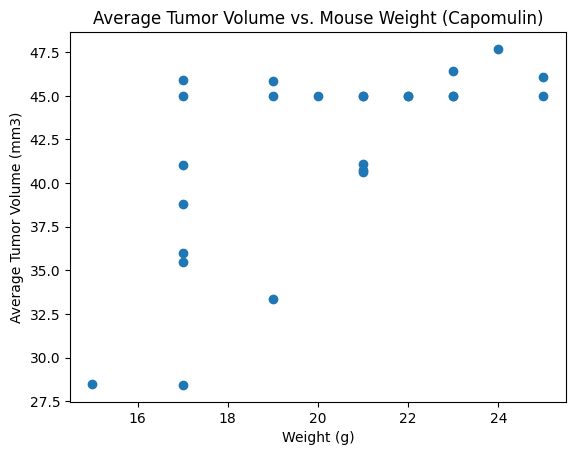

In [31]:
# Select a single mouse treated with Capomulin for the line plot
capomulin_mouse = merged_df[(merged_df["Drug Regimen"] == "Capomulin") & (merged_df["Mouse ID"] == "s185")]

# Plot the tumor volume over time
plt.plot(capomulin_mouse["Timepoint"], capomulin_mouse["Tumor Volume (mm3)"], marker="o")
plt.title("Tumor Volume vs. Time Point for Mouse s185 (Capomulin)")
plt.xlabel("Time Point (days)")
plt.ylabel("Tumor Volume (mm3)")
plt.grid(True)  # Optional: Adds a grid for better readability
plt.show()

# Scatter plot of mouse weight vs. average tumor volume for Capomulin regimen
capomulin_data = cleaned_df[cleaned_df["Drug Regimen"] == "Capomulin"]
avg_tumor_volume = capomulin_data.groupby("Mouse ID").mean(numeric_only=True)["Tumor Volume (mm3)"]
mouse_weights = capomulin_data.groupby("Mouse ID").mean(numeric_only=True)["Weight (g)"]
plt.scatter(mouse_weights, avg_tumor_volume)
plt.title("Average Tumor Volume vs. Mouse Weight (Capomulin)")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()
    

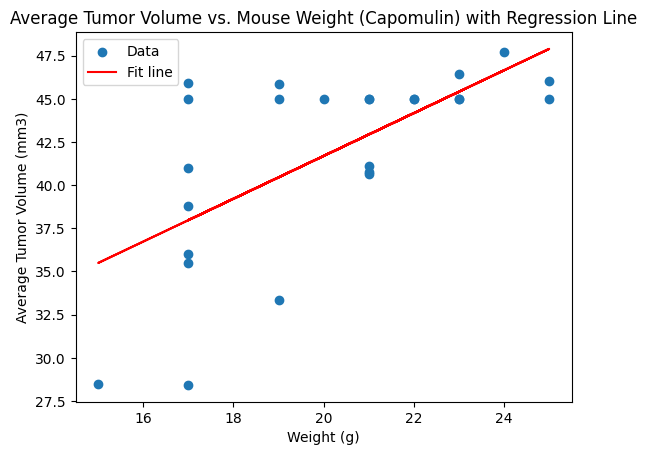

0.6464711142681775

In [22]:
# Correlation and Regression
# Calculate the correlation coefficient and linear regression for Capomulin regimen
slope, intercept, r_value, p_value, std_err = linregress(mouse_weights, avg_tumor_volume)

# Plotting scatter plot with linear regression line
plt.scatter(mouse_weights, avg_tumor_volume, label="Data")
plt.plot(mouse_weights, slope * mouse_weights + intercept, color="red", label="Fit line")
plt.title("Average Tumor Volume vs. Mouse Weight (Capomulin) with Regression Line")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.legend()
plt.show()

# Display correlation coefficient
r_value
    

In [23]:

# Generate a summary statistics table for each drug regimen
summary_stats = merged_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].agg(
    mean="mean",
    median="median",
    variance="var",
    std_dev="std",
    SEM="sem"
).reset_index()

# Display the summary statistics table
summary_stats


,Drug Regimen,mean,median,variance,std_dev,SEM
0,Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
1,Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
2,Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
3,Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
4,Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
5,Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
6,Propriva,52.322552,50.854632,42.351070,6.507770,0.512884
7,Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
8,Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111
9,Zoniferol,53.236507,51.818479,48.533355,6.966589,0.516398
